<a href="https://colab.research.google.com/github/palaceIA/CICS_Project/blob/main/src/notebooks/electra/electra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning Electra Base Discriminator

Esse jupyter faz parte na nossa pesquisa para o Congresso Internacional (CICS) , aqui você ira encontrar nosso experimento referente ao modelo Electra e os nossos devidos resultados. O dataset utlizado foi o "dair-ai/emotion" disponivel no HuggingFace .

## Electra-base-discriminator
ELECTRA é um novo método para aprendizado de representação de linguagem autosupervisionado. Ele pode ser usado para pré-treinar redes de transformadores usando relativamente pouca computação. Os modelos ELECTRA são treinados para distinguir tokens de entrada "reais" vs tokens de entrada "falsos" gerados por outra rede neural, semelhante ao discriminador de uma GAN . Em pequena escala, ELECTRA alcança resultados fortes mesmo quando treinado em uma única GPU. Em grande escala, ELECTRA alcança resultados de última geração no conjunto de dados SQuAD 2.0 .

Ele suporta ajuste fino de ELECTRA em tarefas downstream, incluindo tarefas de classificação (por exemplo, GLUE ), tarefas de QA (por exemplo, SQuAD ) e tarefas de marcação de sequência (por exemplo, text chunking ).

In [1]:
# Instalando os modulos
!pip install torch transformers datasets matplotlib numpy scikit-learn pandas scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Carregando os modulos

In [2]:

from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    AutoTokenizer,
    AutoModel ,
    Trainer
)
from sklearn.metrics import (
    accuracy_score ,
    f1_score ,
    classification_report ,
    roc_curve ,
    auc
)
from scipy.special import softmax
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

## Carregando o dataset

In [ ]:
id_data = "dair-ai/emotion"
dataset = load_dataset(id_data)

## Entendendo os dados

In [4]:
# Estrutura do dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [5]:
# Total de classes do dataset
classes = dataset['train'].features['label'].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [6]:
# Alterando o formato do dataset para um tipo pandas
dataset.set_format(type='pandas')
df_pandas = dataset['train'][:]
df_pandas.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [7]:
# Criando uma tabela para cada classe correspondente
df_pandas['label_name'] = df_pandas['label'].apply(lambda x : classes[x])
df_pandas.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [8]:
# Verificando o balanceamento das classes
total_classes = df_pandas['label_name'].value_counts()
total_classes

,count
label_name,
joy,5362
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572


In [9]:
# Resetando o formato original dos dados
dataset.reset_format()

## Carregando o tokenizador do modelo

In [ ]:
id_model = 'google/electra-base-discriminator'
tokenizador = AutoTokenizer.from_pretrained(id_model)

In [11]:
# passaremos a quantidade de batchs dos dados
# Para aplicar essas a tokenizaço de todos os dados
# basta usar o metodo map()
# Função para tokenizar o dataset
def tokenizador_lote(batch):
    temp = tokenizador(
        batch['text'],  # Aqui, 'batch' deve ser um dicionário com uma chave 'text'
        padding=True,
        truncation=True,
    )
    return temp


## Tokenizando dados

In [ ]:
dataset_tokenizado = dataset.map(
    tokenizador_lote,
    batched = True ,
    batch_size=None
)

## Carregando modelo

In [ ]:
model= AutoModel.from_pretrained(id_model)

In [14]:
model

ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0-11): 12 x ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0

## Configurações iniciais para o ajuste fino

In [15]:
# Armazenando numero de classes
numero_classes = len(classes)
# Inicializando plataforma CUDA
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
model = AutoModelForSequenceClassification.from_pretrained(
    id_model , num_labels = numero_classes
)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
device

device(type='cuda')

In [17]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [18]:
!nvidia-smi

Wed Apr  9 21:41:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Configurações do treinamento

In [19]:
# Tamanho do lote
batch_size = 15
model_name = 'electra-base-discriminator-emotions'

training_args = TrainingArguments(
    output_dir=model_name ,
    num_train_epochs=4 ,
    learning_rate=1e-5,
    per_device_train_batch_size= batch_size ,
    per_device_eval_batch_size=batch_size ,
    weight_decay=0.01,
    eval_strategy='epoch' ,
    disable_tqdm=False

)

## Computação de métricas

In [20]:
def computer_metrics(pred) :
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels,preds,average='weighted')
    acc = accuracy_score(labels,preds)
    return {"acurracy" : acc , "f1" : f1}

## Treinamento

In [21]:
trainer = Trainer(
    model = model ,
    args = training_args ,
    compute_metrics = computer_metrics ,
    train_dataset = dataset_tokenizado['train'] ,
    eval_dataset= dataset_tokenizado['validation'] ,
    tokenizer = tokenizador
)

<ipython-input-21-fe59b000d80f>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [22]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: caiopalacio16 (caiopalacio16-unifsa) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Acurracy,F1
1,0.730800,0.447234,0.871000,0.865521
2,0.286400,0.250207,0.923500,0.923376
3,0.188300,0.222281,0.930500,0.930807
4,0.156600,0.209966,0.934000,0.933927


TrainOutput(global_step=4268, training_loss=0.41134328314826774, metrics={'train_runtime': 1294.9799, 'train_samples_per_second': 49.422, 'train_steps_per_second': 3.296, 'total_flos': 2861435490048000.0, 'train_loss': 0.41134328314826774, 'epoch': 4.0})

## Avaliando modelo

In [23]:
pred_ouptus = trainer.predict(
    dataset_tokenizado['test']
)
pred_ouptus.metrics

{'test_loss': 0.21380382776260376,
 'test_acurracy': 0.927,
 'test_f1': 0.9268096666189627,
 'test_runtime': 8.6841,
 'test_samples_per_second': 230.307,
 'test_steps_per_second': 15.431}

In [24]:
y_pred = np.argmax(
    pred_ouptus.predictions,axis=1
)
y_test = dataset_tokenizado['test'][:]['label']

In [25]:
y_pred[:5]

array([0, 0, 0, 1, 0])

In [26]:
y_test[:5]

[0, 0, 0, 1, 0]

In [27]:
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [28]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     sadness       0.96      0.96      0.96       581
         joy       0.96      0.94      0.95       695
        love       0.82      0.86      0.84       159
       anger       0.93      0.91      0.92       275
        fear       0.86      0.92      0.89       224
    surprise       0.82      0.68      0.74        66

    accuracy                           0.93      2000
   macro avg       0.89      0.88      0.88      2000
weighted avg       0.93      0.93      0.93      2000



In [29]:
report_dict = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
report_dict

{'sadness': {'precision': 0.958904109589041,
  'recall': 0.963855421686747,
  'f1-score': 0.9613733905579399,
  'support': 581.0},
 'joy': {'precision': 0.9576642335766423,
  'recall': 0.943884892086331,
  'f1-score': 0.9507246376811594,
  'support': 695.0},
 'love': {'precision': 0.8242424242424242,
  'recall': 0.8553459119496856,
  'f1-score': 0.8395061728395061,
  'support': 159.0},
 'anger': {'precision': 0.9261992619926199,
  'recall': 0.9127272727272727,
  'f1-score': 0.9194139194139194,
  'support': 275.0},
 'fear': {'precision': 0.8583333333333333,
  'recall': 0.9196428571428571,
  'f1-score': 0.8879310344827587,
  'support': 224.0},
 'surprise': {'precision': 0.8181818181818182,
  'recall': 0.6818181818181818,
  'f1-score': 0.743801652892562,
  'support': 66.0},
 'accuracy': 0.927,
 'macro avg': {'precision': 0.8905875301526466,
  'recall': 0.8795457562351792,
  'f1-score': 0.8837918013113075,
  'support': 2000.0},
 'weighted avg': {'precision': 0.927362969588091,
  'recall': 

In [30]:
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.round(4)

In [31]:
# Exibe a tabela
print(report_df)

              precision  recall  f1-score   support
sadness          0.9589  0.9639    0.9614   581.000
joy              0.9577  0.9439    0.9507   695.000
love             0.8242  0.8553    0.8395   159.000
anger            0.9262  0.9127    0.9194   275.000
fear             0.8583  0.9196    0.8879   224.000
surprise         0.8182  0.6818    0.7438    66.000
accuracy         0.9270  0.9270    0.9270     0.927
macro avg        0.8906  0.8795    0.8838  2000.000
weighted avg     0.9274  0.9270    0.9268  2000.000


In [32]:

def plot_multiclass_roc(y_true, y_probs, class_names):
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Falso Positivo')
    plt.ylabel('Verdadeiro Positivo')
    plt.title('Curvas ROC por Emoção')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


In [33]:
pred = trainer.predict(dataset_tokenizado['test'])

In [34]:
# Aplica softmax sobre os logits
y_pred_proba = softmax(pred.predictions, axis=1)

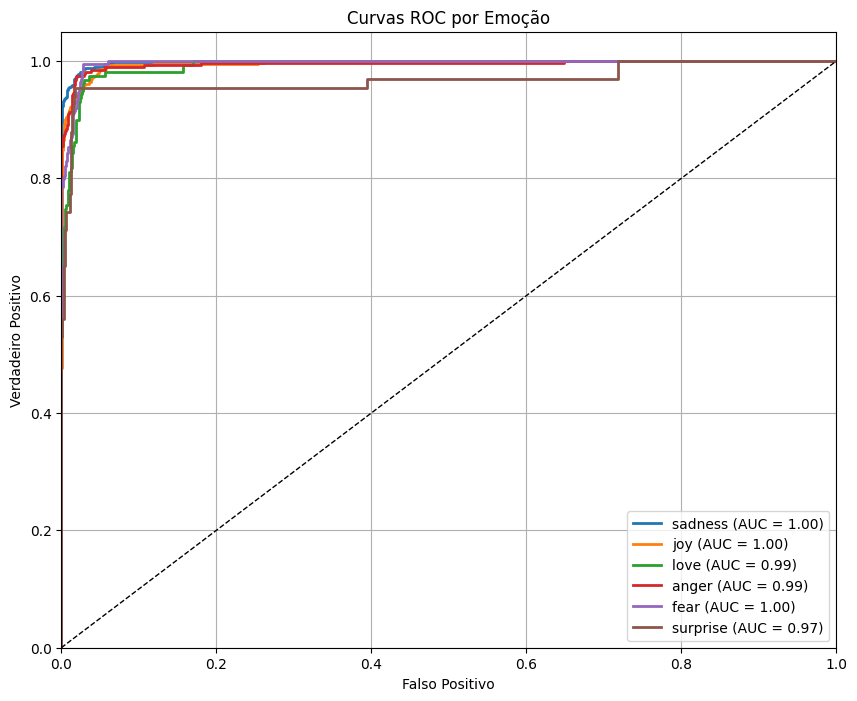

In [35]:
plot_multiclass_roc(y_test, y_pred_proba, classes)

In [36]:

def get_roc_dataframe(y_true, y_probs, class_names):
    n_classes = len(classes)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    dataframes = []

    for i in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)

        df = pd.DataFrame({
            'class': classes[i],
            'fpr': fpr,
            'tpr': tpr,
            'threshold': thresholds,
            'auc': roc_auc  # mesmo valor repetido pra cada linha, pra facilitar agrupamentos
        })

        dataframes.append(df)

    return pd.concat(dataframes, ignore_index=True)


In [37]:
roc_df = get_roc_dataframe(y_test, y_pred_proba,classes)
roc_df

,class,fpr,tpr,threshold,auc
0,sadness,0.000000,0.000000,inf,0.997418
1,sadness,0.000000,0.001721,0.997756,0.997418
2,sadness,0.000000,0.079174,0.997697,0.997418
3,sadness,0.000000,0.082616,0.997696,0.997418
4,sadness,0.000000,0.108434,0.997687,0.997418
...,...,...,...,...,...
553,surprise,0.394002,0.954545,0.000570,0.968530
554,surprise,0.394002,0.969697,0.000563,0.968530
555,surprise,0.718718,0.969697,0.000221,0.968530
556,surprise,0.718718,1.000000,0.000205,0.968530


In [38]:
roc_df.to_csv("curva_roc_por_classe.csv", index=False)